In [80]:
%matplotlib inline
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import skimage.segmentation

# Load a single image and its associated masks
id = '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
file = "../input/stage1_train/{}/images/{}.png".format(id,id)
masks = "../input/stage1_train/{}/masks/*.png".format(id)
image = skimage.io.imread(file)
masks = skimage.io.imread_collection(masks).concatenate()
height, width, _ = image.shape
num_masks = masks.shape[0]
print(num_masks)
# from IPython.core.debugger import Tracer; Tracer()()

27


In [81]:
# Make a ground truth label image (pixel value is index of object label)
labels = np.zeros((height, width), np.uint16)
for index in range(0, num_masks):
    labels[masks[index] > 0] = index + 1

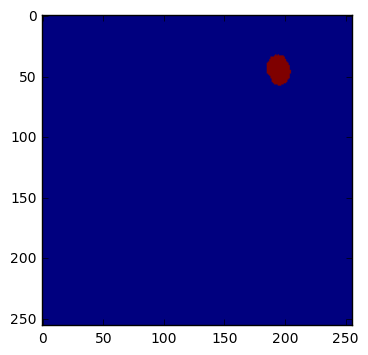

In [90]:
plt.imshow(masks[19])

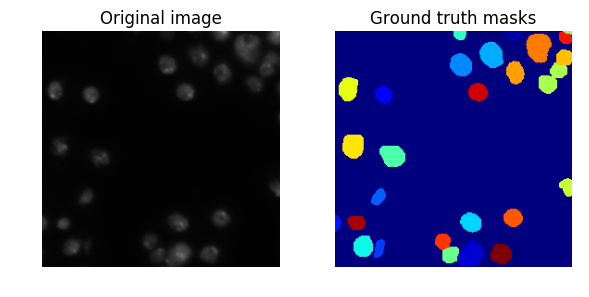

In [35]:
# Show label image
fig, axes = plt.subplots(1,2, figsize=(6,4))
axes[0].imshow(image)
axes[0].set_title("Original image")
axes[1].imshow(labels)
axes[1].set_title("Ground truth masks")
plt.tight_layout()
for ax in axes:
    ax.axis('off')

In [124]:
# Simulate an imperfect submission
offset = 2 # offset pixels
y_pred = labels[offset:, offset:]
y_pred = np.pad(y_pred, ((0, offset), (0, offset)), mode="constant")
y_pred[y_pred == 20] = 0 # Remove one object
y_pred, _, _ = skimage.segmentation.relabel_sequential(y_pred) # Relabel objects
y_pred = labels

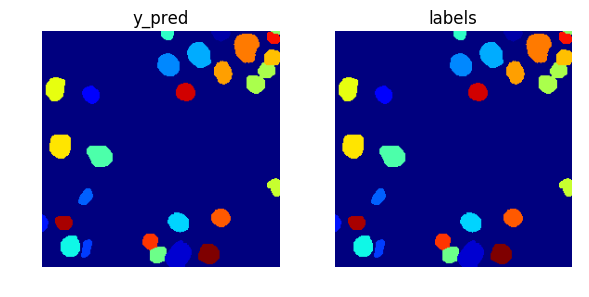

In [125]:
fig, axes = plt.subplots(1,2, figsize=(6,4))
axes[0].imshow(y_pred)
axes[0].set_title("y_pred")
axes[1].imshow(labels)
axes[1].set_title("labels")
plt.tight_layout()
for ax in axes:
    ax.axis('off')

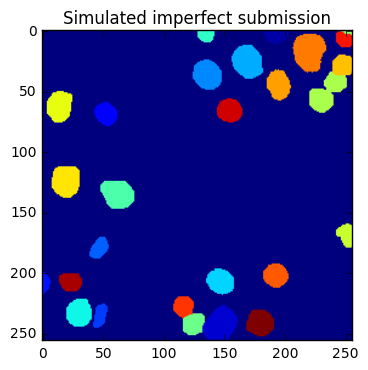

In [126]:
# Show simulated predictions
fig = plt.figure()
plt.imshow(y_pred)
plt.title("Simulated imperfect submission")

[[  1.   2.   3.   4.]
 [  5.   6.   7.   8.]
 [  9.  10.  11.  12.]
 [ 13.  14.  15.  16.]]
(100,)


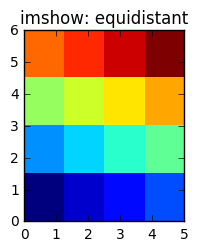

In [46]:
xedges = [0, 1, 1.5, 3, 5]
yedges = [0, 2, 3, 4, 6]



x = np.random.normal(3, 1, 100)
y = np.random.normal(1, 1, 100)
H, xedges, yedges = np.histogram2d(y, x, bins=(xedges, yedges))


H = np.ones((4, 4)).cumsum().reshape(4, 4)
# print(H[::-1])  # This shows the bin content in the order as plotted
print(H)
print(y.shape)

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131)
ax.set_title('imshow: equidistant')
im = plt.imshow(H, interpolation='nearest', origin='low',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])


In [127]:
# Compute number of objects
true_objects = len(np.unique(labels))
pred_objects = len(np.unique(y_pred))
print("Number of true objects:", true_objects)
print("Number of predicted objects:", pred_objects)

Number of true objects: 28
Number of predicted objects: 28


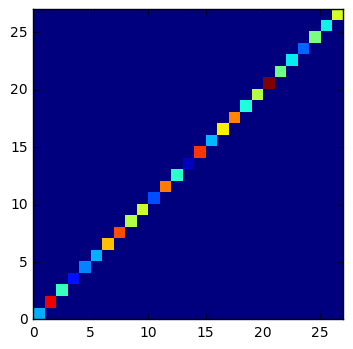

In [128]:
# Compute intersection between all objects
intersection, xedges, yedges = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))

plt.imshow(intersection[1:,1:], interpolation='nearest', origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [129]:
# Compute areas (needed for finding the union between all objects)
area_true, atbins = np.histogram(labels, bins = true_objects)[:2]
area_pred, apbins = np.histogram(y_pred, bins = pred_objects)[:2]
area_true = np.expand_dims(area_true, -1)
area_pred = np.expand_dims(area_pred, 0)

In [130]:
area_pred

array([[56486,   200,   605,   280,    95,   171,   200,   472,   554,
          379,   401,   134,   521,   270,    37,   572,   205,   439,
          513,   258,   379,   669,   324,   239,   149,   332,   244,
          408]])

In [131]:
# Compute union
union = area_true + area_pred - intersection

In [132]:
# Exclude background from the analysis
intersection = intersection[1:,1:]
union = union[1:,1:]
union[union == 0] = 1e-9

In [133]:
# Compute the intersection over union
iou = intersection / union

In [134]:
(iou < 1).all()

False

In [135]:
threshold = 0.5
matches = iou > threshold
np.sum(matches, axis=1).shape


(27,)

In [136]:
# Precision helper function
def precision_at(threshold, iou):
    matches = iou > threshold # 0.5, 0.55, 0.6, 0.65, ... , 0.95
    true_positives = np.sum(matches, axis=1) == 1   # Correct Objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra Objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed Objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

In [137]:
# Loop over IoU thresholds
prec = []
print("Thresh\tTP\tFP\tFN\tPrec.")
for t in np.arange(0.5, 1.0, 0.05):
    tp, fp, fn = precision_at(t, iou)
    p = tp / (tp + fp + fn)
    print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
    prec.append(p)
print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

Thresh	TP	FP	FN	Prec.
0.500	27	0	0	1.000
0.550	27	0	0	1.000
0.600	27	0	0	1.000
0.650	27	0	0	1.000
0.700	27	0	0	1.000
0.750	27	0	0	1.000
0.800	27	0	0	1.000
0.850	27	0	0	1.000
0.900	27	0	0	1.000
0.950	27	0	0	1.000
AP	-	-	-	1.000


1. Unet is the not best for this.
2. 